# Lab 1.2: Node Embedding, Node Classification, and Link Prediction

**Objectives:** 
- Implement different traditional and embedding-based graph representation learning methods
- Compare and analyse the performances of the methods for embedding learning, node classification and link prediction tasks. 

**Completion requirements:**

By the end of this notebook, you should have:
- Implemented all code cells for:
  - the representation learning methods. 
  - training the methods.
  - assesing the performance of the methods.
- Answered the analysis questions on each section. 

## Libraries

<!-- 
# If you have not installed pytorch geometric uncomment the following lines to install it

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# !pip install wntr -->

To run this notebook you need to have installed the following packages:

- TDC
- Numpy
- Pytorch
- NetworkX
- Matplotlib
- Scikit-learn
- Pytorch geometric  

Run the following code to import the packages

In [1]:
# pip install torch_geometric

In [2]:
# import the libraries
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# import the functions
from numpy import dot
import torch.nn as nn
from sklearn import metrics
from numpy.linalg import norm
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import mask as Mask
from torch_geometric.utils import to_networkx
from torch_geometric.nn.models import Node2Vec
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split

# import the datasets

from torch_geometric.datasets import Planetoid

---

## Lab 1.2.2: Node Classification

### ⛔ Problem definition 

Node Classification is a machine learning task in graph-based data analysis, where the goal is to assign labels to nodes in a graph based on the properties of nodes and the relationships between them.

Node Classification models aim to predict non-existing node properties (known as the target property) based on other node properties. Model performance can be measured using benchmark datasets like Cora, Citeseer, and Pubmed, among others, typically using Accuracy and F1. In this exercise, we use accuracy.

The dataset needs to be split for the node classification task, and the performance of the model is measured by its accuracy on the test set. Cora has the built in split. We will use its default split in this exercise.

### 🕵 <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

**(a)Use the hand-crafted features as input, perform node classification using a 2-layer Multi-Layer Perceptron(MLP).**

The hyperparameters for the MLP should be as follows: 

    - the input dimensions are same as the dimensions of input features
    - hidden unit dimension is set to be 16
    - output dimensions should be the number of classes to predict
    - use relu as activate function 
    - train the MLP for 200 epochs

Which loss would you use for training the MLP? Answer in the following cell:

**Answer here:** 

<font color='red'>nn.CrossEntropyLoss() is able to operate on categorical labels and would be a suitable choice given the data.</font>


In the following cell, define a two layer MLP using the parameters given above:

In [3]:
######################################################################### 
# define a two layer MLP
class MLP(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MLP, self).__init__()
        self.lin1 = torch.nn.Linear(in_channels, 16)
        self.relu1 = torch.nn.ReLU()
        self.lin2 = torch.nn.Linear(16, out_channels)

    def forward(self, x):
        x = self.lin1(x)
        x = self.relu1(x)
        x = self.lin2(x)
        return x

#########################################################################


In the following cell, train your MLP for 200 epochs and print the training loss, accuracy on the test set for each epoch:

Number of input features:  1433
Number of classes:  7
Number of nodes:  2708
Number of edges:  10556


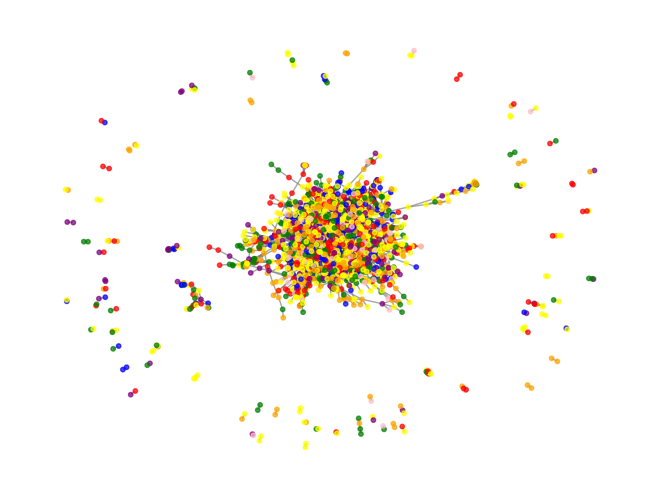

In [4]:
# DATA VISUALIZATION BLOCK

# the input dimensions are same as the dimensions of input features

cora_dataset = Planetoid(root="", name="Cora", split="public")
data = cora_dataset[0]

# how many input features are there?
print("Number of input features: ", data.num_features)

# how many output classes are there?
# the number of output classes are the number of unique elements in the target tensor
print("Number of classes: ", len(torch.unique(data.y)))

# how may nodes are in the graph
print("Number of nodes: ", data.num_nodes)

# what are the edges in the graph?
print("Number of edges: ", data.num_edges)

# Create a networkx graph from the data
G = nx.Graph()
G.add_edges_from(data.edge_index.T.tolist())

# Get the output class labels for each node
labels = data.y.tolist()

# Define a color map based on the output class labels
color_map = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow', 4: 'orange', 5: 'purple', 6: 'pink'}

# Draw the graph with colored nodes based on the output class
nx.draw(G, with_labels=False, node_color=[color_map[label] for label in labels], edge_color='gray', alpha=0.7, node_size=10)
plt.show()


## CONTINUES BELOW



In [5]:
# Now we will use the handcrafted features to learn node embeddings

# HANDCRAFTED FEATURES
# call the corresponding functions to calculate the hand crafted features
degree_centrality = nx.degree_centrality(G)
clustering_coefficient = nx.clustering(G)
betweeness_centrality = nx.betweenness_centrality(G)

# Concatanate the features to be a feature vector
features = []
for i in range(data.x.shape[0]):
    # print(degree_centrality[i], clustering_coefficient[i], betweeness_centrality[i])
    features.append([degree_centrality[i], clustering_coefficient[i], betweeness_centrality[i]])
handcrafted_features = np.array(features)

In [6]:
######################################################################### 
# had issues with data being redefined so for safety am including it above every section
cora_dataset = Planetoid(root="", name="Cora", split="public")
data = cora_dataset[0]

# instantiate your MLP model here - ADAPT TO USE HANDCRAFTED FEATURES
in_channels = handcrafted_features.shape[1]               # number of input features
out_channels = len(torch.unique(data.y))    # number of possible output classes
mlp_model = MLP(in_channels, out_channels)

print("The dimension of the handcrafted features are: ", handcrafted_features.shape)
print("Comparing this to the origional case, the input would have been previously: ", data.x.shape)
print("The number of in channels is therefore now: ", in_channels)
print("The number of out channels remains the same at: ", out_channels)

# REPLACE THE DATA.X WITH HANDCRAFTED FEATURES
data.x = torch.tensor(handcrafted_features, dtype=torch.float).clone().detach().requires_grad_(True)

print("The data.x has been replaced with the handcrafted features", data.x.shape)

######################################################################### 

######################################################################### 
# define a training function for a simple MLP model running over 200 epochs
def train(model, data, optimizer, criterion, num_epochs):
    test_acc_list = []
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(data.x)  # replace data.x with handcrafted_features
        loss = criterion(output[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        # print accuracy at every epoch
        test_acc = test(model, data)
        test_acc_list.append(test_acc)
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {loss.item()} -  Accuracy: {test_acc:.4f}")
    return test_acc_list

######################################################################### 

######################################################################### 
# define a test function
def test(model, data):
    model.eval()
    output = model(data.x)  # replace data.x with handcrafted_features
    
    _, predicted = torch.max(output[data.test_mask], 1)     # get the classifications from the model's output
    
    accuracy = torch.sum(predicted == data.y[data.test_mask]).item() / data.test_mask.sum().item()
    return accuracy

#########################################################################

######################################################################### 
#train your model here and print the accuracy

test_acc_list = train(model=mlp_model, data=data, optimizer=torch.optim.Adam(mlp_model.parameters(), lr=0.01), criterion=nn.CrossEntropyLoss(), num_epochs=200)
acc = test(model=mlp_model, data=data)

#########################################################################


The dimension of the handcrafted features are:  (2708, 3)
Comparing this to the origional case, the input would have been previously:  torch.Size([2708, 1433])
The number of in channels is therefore now:  3
The number of out channels remains the same at:  7
The data.x has been replaced with the handcrafted features torch.Size([2708, 3])
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch 5/200 - Loss: 1.9534536600112915 -  Accuracy: 0.0870
Epoch 10/200 - Loss: 1.9447195529937744 -  Accuracy: 0.1700
Epoch 15/200 - Loss: 1.9407590627670288 -  Accuracy: 0.1490
Epoch 20/200 - Loss: 1.9365371465682983 -  Accuracy: 0.1600
Epoch 25/200 - Loss: 1.9319778680801392 -  Accuracy: 0.1520
Epoch 30/200 - Loss: 1.927668809890747 -  Accuracy: 0.1240
Epoch 35/200 - Loss: 1.9239262342453003 -  Accuracy: 

In the following cell, visualize the accuracy on the test set in each epoch:

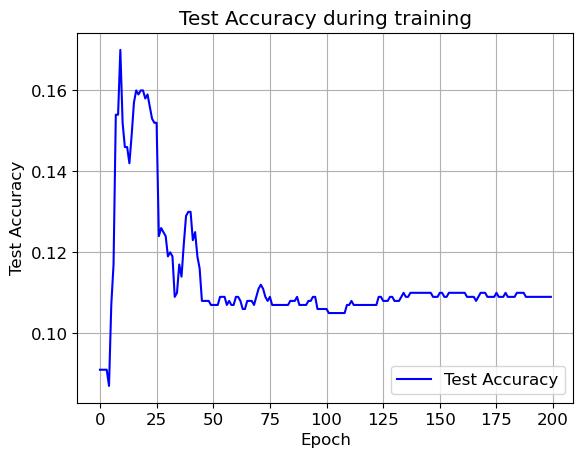

In [7]:
######################################################################### 
# visualize the accuracy on the test set as a function to the epochs

# Set the font size for the plot labels and title
plt.rcParams.update({'font.size': 12})

# Create a figure and axis object
fig, ax = plt.subplots()

# Set the x-axis values to epoch_list

# Plot the training loss as a blue line
ax.plot(test_acc_list, 'b-', label="Test Accuracy")

# Add a legend to the plot
ax.legend(loc='lower right')

# Set the plot labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy during training')

# Add grid lines to the plot
ax.grid(True, which='both')

# Display the plot
plt.show()

### 🕵 <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

**(b)Repeat the node classification task using features generated from Node2Vec above**

In [8]:
node2vec_features = np.load("../Part2-1_NodeEmbeddings/embedding.npy")

In [9]:
######################################################################### 
# had issues with data being redefined so for safety am including it above every section
cora_dataset = Planetoid(root="", name="Cora", split="public")
data = cora_dataset[0]

# instantiate your MLP model here - ADAPT TO USE NODE2VEC FEATURES
in_channels = node2vec_features.shape[1]               # number of input features
out_channels = len(torch.unique(data.y))    # number of possible output classes
mlp_model = MLP(in_channels, out_channels)

# REPLACE THE DATA.X WITH NODE2VEC FEATURES
data.x = torch.tensor(node2vec_features, dtype=torch.float).clone().detach().requires_grad_(True)

######################################################################### 

######################################################################### 
#get the features generated from the Node2Vec trained above -- SEE ABOVE

######################################################################### 

######################################################################### 
#train function for MLP
def train(model, data, optimizer, criterion, num_epochs):
    test_acc_list = []
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(data.x)  # replace data.x with handcrafted_features
        loss = criterion(output[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        test_acc = test(model, data)
        test_acc_list.append(test_acc)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {loss.item()} -  Accuracy: {test_acc:.4f}")
    return test_acc_list

######################################################################### 

######################################################################### 
# test function for your MLP
def test(model, data):
    model.eval()
    output = model(data.x)  # replace data.x with handcrafted_features
    _, predicted = torch.max(output[data.test_mask], 1)     # get the classifications from the model's output
    return torch.sum(predicted == data.y[data.test_mask]).item() / data.test_mask.sum().item()
    


######################################################################### 

In [10]:
######################################################################### 
# train your model here:
#train your model here and print the accuracy

test_acc_list = train(model=mlp_model, data=data, optimizer=torch.optim.Adam(mlp_model.parameters(), lr=0.01), criterion=nn.CrossEntropyLoss(), num_epochs=200)
acc = test(model=mlp_model, data=data)

######################################################################### 

Epoch 10/200 - Loss: 1.671561360359192 -  Accuracy: 0.4430
Epoch 20/200 - Loss: 1.3827884197235107 -  Accuracy: 0.6090
Epoch 30/200 - Loss: 1.1526609659194946 -  Accuracy: 0.6410
Epoch 40/200 - Loss: 1.0241342782974243 -  Accuracy: 0.6460
Epoch 50/200 - Loss: 0.9625766277313232 -  Accuracy: 0.6530
Epoch 60/200 - Loss: 0.929554283618927 -  Accuracy: 0.6530
Epoch 70/200 - Loss: 0.9071400165557861 -  Accuracy: 0.6520
Epoch 80/200 - Loss: 0.8888143301010132 -  Accuracy: 0.6480
Epoch 90/200 - Loss: 0.8738123774528503 -  Accuracy: 0.6440
Epoch 100/200 - Loss: 0.8612862229347229 -  Accuracy: 0.6430
Epoch 110/200 - Loss: 0.8498655557632446 -  Accuracy: 0.6390
Epoch 120/200 - Loss: 0.838746190071106 -  Accuracy: 0.6380
Epoch 130/200 - Loss: 0.8278807401657104 -  Accuracy: 0.6360
Epoch 140/200 - Loss: 0.8177437782287598 -  Accuracy: 0.6350
Epoch 150/200 - Loss: 0.8074982166290283 -  Accuracy: 0.6330
Epoch 160/200 - Loss: 0.7975896596908569 -  Accuracy: 0.6310
Epoch 170/200 - Loss: 0.787794530391

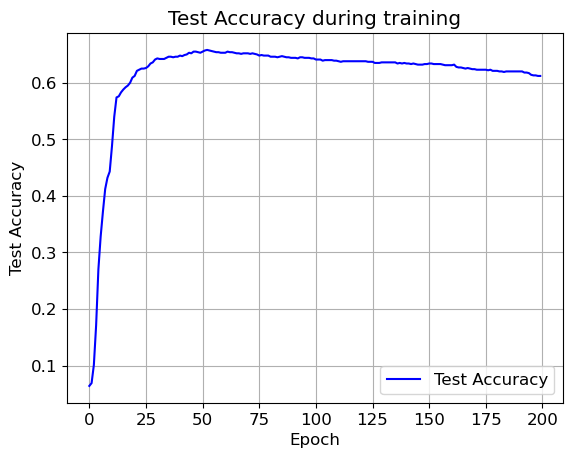

In [11]:
######################################################################### 
# visualize the accuracy on the test set as a function to the epochs

plt.rcParams.update({'font.size': 12})

# Create a figure and axis object
fig, ax = plt.subplots()

# Set the x-axis values to epoch_list

# Plot the training loss as a blue line
ax.plot(test_acc_list, 'b-', label="Test Accuracy")

# Add a legend to the plot
ax.legend(loc='lower right')

# Set the plot labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy during training')

# Add grid lines to the plot
ax.grid(True, which='both')

# Display the plot
plt.show()
######################################################################### 

### 🕵 <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

**(c)Repeat the node classification task using original features from Cora dataset**

In [12]:
######################################################################### 
# had issues with data being redefined so for safety am including it above every section
cora_dataset = Planetoid(root="", name="Cora", split="public")
data = cora_dataset[0]

# instantiate another MLP with the same parameters
# MLP node using cora features
in_channels = data.x.shape[1]               # number of input features
out_channels = len(torch.unique(data.y))    # number of possible output classes
mlp_model = MLP(in_channels, out_channels)

######################################################################### 

######################################################################### 
#define a train function for your model
def train(model, data, optimizer, criterion, num_epochs):
    model.train()
    test_acc_list = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(data.x)
        loss = criterion(output[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        test_acc = test(model, data)
        test_acc_list.append(test_acc)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {loss.item()} -  Accuracy: {test_acc:.4f}")
    return test_acc_list


######################################################################### 

######################################################################### 
#define a test function to your model
def test(model, data):
    model.eval()
    output = model(data.x)
    _, predicted = torch.max(output[data.test_mask], 1)     # get the classifications from the model's output
    accuracy = torch.sum(predicted == data.y[data.test_mask]).item() / data.test_mask.sum().item()
    return accuracy

######################################################################### 

In [13]:
######################################################################### 
#train your model and print the accuracy

test_acc_list = train(model=mlp_model, data=data, optimizer=torch.optim.Adam(mlp_model.parameters(), lr=0.01), criterion=nn.CrossEntropyLoss(), num_epochs=200)
acc = test(model=mlp_model, data=data)

######################################################################### 

Epoch 10/200 - Loss: 0.7277686595916748 -  Accuracy: 0.3560
Epoch 20/200 - Loss: 0.10257389396429062 -  Accuracy: 0.4900
Epoch 30/200 - Loss: 0.02773495763540268 -  Accuracy: 0.4950
Epoch 40/200 - Loss: 0.011131023056805134 -  Accuracy: 0.4760
Epoch 50/200 - Loss: 0.006068781483918428 -  Accuracy: 0.4720
Epoch 60/200 - Loss: 0.004096808843314648 -  Accuracy: 0.4710
Epoch 70/200 - Loss: 0.0031210354063659906 -  Accuracy: 0.4660
Epoch 80/200 - Loss: 0.0025407716166228056 -  Accuracy: 0.4650
Epoch 90/200 - Loss: 0.002146545797586441 -  Accuracy: 0.4650
Epoch 100/200 - Loss: 0.0018539471784606576 -  Accuracy: 0.4680
Epoch 110/200 - Loss: 0.001624868717044592 -  Accuracy: 0.4680
Epoch 120/200 - Loss: 0.0014398308703675866 -  Accuracy: 0.4710
Epoch 130/200 - Loss: 0.0012867390178143978 -  Accuracy: 0.4710
Epoch 140/200 - Loss: 0.0011579673737287521 -  Accuracy: 0.4710
Epoch 150/200 - Loss: 0.0010484671220183372 -  Accuracy: 0.4720
Epoch 160/200 - Loss: 0.0009543632040731609 -  Accuracy: 0.47

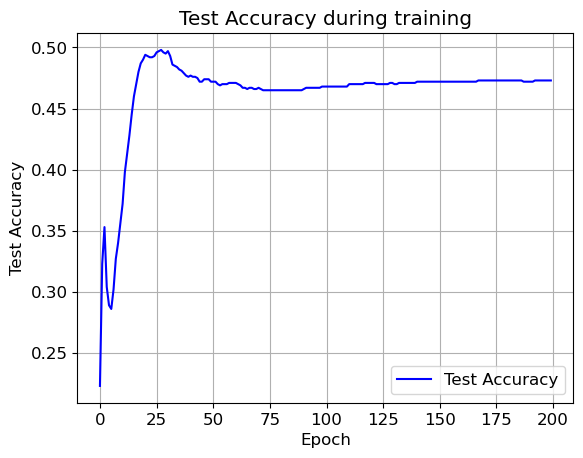

In [14]:
######################################################################### 
# visualize the accuracy on the test set as a function to the epochs

# Set the font size for the plot labels and title
plt.rcParams.update({'font.size': 12})

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training loss as a blue line
ax.plot(test_acc_list, 'b-', label="Test Accuracy")

# Add a legend to the plot
ax.legend(loc='lower right')

# Set the plot labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy during training')

# Add grid lines to the plot
ax.grid(True, which='both')

# Display the plot
plt.show()
######################################################################### 

### 🕵 <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

**(d)Run label propagation algorithm on Cora for 10 iterations. Specifically use the row normailized adjancency matrix as the transition matrix. You can pad the label vectors for the test nodes using zero padding as initialization.**

In [15]:
######################################################################### 
# ISSUE TODO: Getting a low accuracy which does not make sense here

# one-hot encode the true label for training data

from sklearn.preprocessing import OneHotEncoder

# had issues with data being redefined so for safety am including it above every section
cora_dataset = Planetoid(root="", name="Cora", split="public")
data = cora_dataset[0]

encoder = OneHotEncoder()
all_labels = encoder.fit_transform(data.y.reshape(-1, 1)).toarray()

######################################################################### 

######################################################################### 
# mask the val and test labels
tr_labels = np.zeros_like(all_labels)
# val_labels = np.zeros_like(all_labels) --- not used
tr_labels[data.train_mask] = all_labels[data.train_mask] 
# val_labels[data.val_mask] = all_labels[data.val_mask] --- not used

#########################################################################

######################################################################### 
# transition matrix as adjacency matrix
transition_matrix = nx.adjacency_matrix(G)

# row normalization
row_sum = np.sum(transition_matrix, axis=1)
transition_matrix = transition_matrix / row_sum[:,None]

######################################################################### 

######################################################################### 
# write code here to run the label propagation algorithm for 10 epochs
# run the label propagation algorithm for 10 epochs
for epoch in range(10):
    tr_labels = np.dot(transition_matrix, tr_labels)

#getting the predicted labels
pred_labels = tr_labels[data.test_mask]
true_labels = all_labels[data.test_mask]
accuracy = metrics.accuracy_score(np.argmax(true_labels, axis=1), np.argmax(pred_labels, axis=1))
print("Accuracy: ", accuracy)


######################################################################### 

Accuracy:  0.11


### 🕵 <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

**(e)(1)Which method perform the best? Give the answer in the following cell:**

Answer: In my experiments, the method that performed the best was the node2vec approach. However, I believe there must be an error in the label propagation component because the accuracy is unusually low.

**(e)(2)What do you conclude about the informativeness of the extracted node feature? Give the answer in the following cell:**

Answer: the better the node is embedded in the feature space (like clustered with like), then the better the performance will be.

**(e)(3)Is there any particular method or embedding quality you would like to comment? Give the answer in the following cell**

Answer: I liked using node2vec for its ease of use and understanding.



### 🕵 <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

**(f)Increase the training set to 80% using one random division and run the above experiments again using hand-crafted features, Node2Vec generated features, original cora features, and label propagation algorithm. Run the code in the following cell to generate a random split.**

In [16]:
num_nodes = data.x.shape[0]
node_ids = [i for i in range(num_nodes)]

# split the nodes into train-val-test: 80-10-10
ids_train, ids_val_test = train_test_split(node_ids, test_size=0.2, random_state=42)
ids_val, ids_test = train_test_split(ids_val_test, test_size=0.5, random_state=41)
train_mask = Mask.index_to_mask(torch.Tensor(ids_train).long(), size=num_nodes)
val_mask = Mask.index_to_mask(torch.Tensor(ids_val).long(), size=num_nodes)
test_mask = Mask.index_to_mask(torch.Tensor(ids_test).long(), size=num_nodes)

In [17]:
# the input dimensions are same as the dimensions of input features

cora_dataset = Planetoid(root="", name="Cora", split="public")
data = cora_dataset[0]

######################################################################### 
# add your code here to run the experiment using hand-crafted features
# import the handcrafted feature from the previous notebook
handcrafted_features = np.load("../Part2-1_NodeEmbeddings/handcrafted_features.npy")

######################################################################### 
# instantiate your MLP model here - ADAPT TO USE HANDCRAFTED FEATURES
in_channels = handcrafted_features.shape[1]               # number of input features
out_channels = len(torch.unique(data.y))    # number of possible output classes
mlp_model = MLP(in_channels, out_channels)

# REPLACE THE DATA.X WITH HANDCRAFTED FEATURES
data.x = torch.tensor(handcrafted_features, dtype=torch.float).clone().detach().requires_grad_(True)

######################################################################### 

######################################################################### 
# define a training function for a simple MLP model running over 200 epochs
def train(model, data, optimizer, criterion, num_epochs):
    model.train()
    test_acc_list = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(data.x)  # replace data.x with handcrafted_features
        loss = criterion(output[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        test_acc = test(model, data)
        test_acc_list.append(test_acc)
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {loss.item()} -  Accuracy: {test_acc:.4f}")
    return test_acc_list
        

######################################################################### 

######################################################################### 
# define a test function
def test(model, data):
    model.eval()
    output = model(data.x)  # replace data.x with handcrafted_features
    
    _, predicted = torch.max(output[data.test_mask], 1)     # get the classifications from the model's output
    
    accuracy = torch.sum(predicted == data.y[data.test_mask]).item() / data.test_mask.sum().item()
    
    return accuracy

#########################################################################

######################################################################### 
#train your model here and print the accuracy

test_acc_list = train(model=mlp_model, data=data, optimizer=torch.optim.Adam(mlp_model.parameters(), lr=0.01), criterion=nn.CrossEntropyLoss(), num_epochs=200)
acc = test(model=mlp_model, data=data)

#########################################################################


######################################################################### 

Epoch 5/200 - Loss: 1.9469051361083984 -  Accuracy: 0.1300
Epoch 10/200 - Loss: 1.9391485452651978 -  Accuracy: 0.0880
Epoch 15/200 - Loss: 1.9351835250854492 -  Accuracy: 0.0860
Epoch 20/200 - Loss: 1.9303451776504517 -  Accuracy: 0.1050
Epoch 25/200 - Loss: 1.9256147146224976 -  Accuracy: 0.2530
Epoch 30/200 - Loss: 1.922299861907959 -  Accuracy: 0.1140
Epoch 35/200 - Loss: 1.9204046726226807 -  Accuracy: 0.1270
Epoch 40/200 - Loss: 1.918967604637146 -  Accuracy: 0.1360
Epoch 45/200 - Loss: 1.917819619178772 -  Accuracy: 0.1190
Epoch 50/200 - Loss: 1.9172018766403198 -  Accuracy: 0.1170
Epoch 55/200 - Loss: 1.9167883396148682 -  Accuracy: 0.1330
Epoch 60/200 - Loss: 1.9162542819976807 -  Accuracy: 0.1270
Epoch 65/200 - Loss: 1.9156930446624756 -  Accuracy: 0.1190
Epoch 70/200 - Loss: 1.9150656461715698 -  Accuracy: 0.1220
Epoch 75/200 - Loss: 1.9144008159637451 -  Accuracy: 0.1120
Epoch 80/200 - Loss: 1.9136993885040283 -  Accuracy: 0.1110
Epoch 85/200 - Loss: 1.9129599332809448 -  A

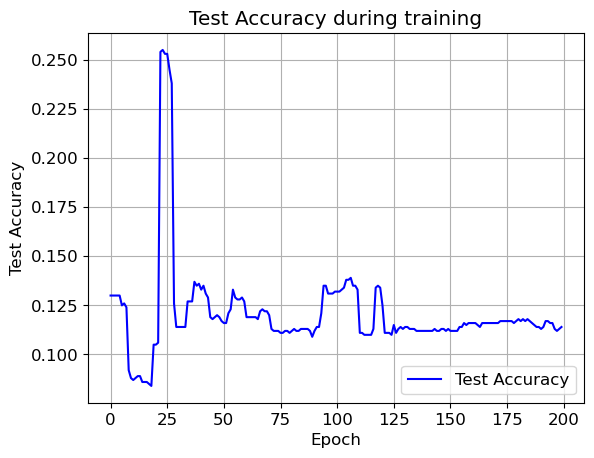

In [18]:
######################################################################### 
# visualize the accuracy on the test set as a function to the epochs

# Set the font size for the plot labels and title
plt.rcParams.update({'font.size': 12})

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training loss as a blue line
ax.plot(test_acc_list, 'b-', label='Test Accuracy')

# Add a legend to the plot
ax.legend(loc='lower right')

# Set the plot labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy during training')

# Add grid lines to the plot
ax.grid(True, which='both')

# Display the plot
plt.show()
######################################################################### 

In [19]:
######################################################################### 
# add your code here to run the experiment using Node2Vec features
# MLP node using node2vec emb

node2vec_features = np.load("../Part2-1_NodeEmbeddings/embedding.npy")

######################################################################### 
# instantiate your MLP model here - ADAPT TO USE NODE2VEC FEATURES
in_channels = node2vec_features.shape[1]               # number of input features
out_channels = len(torch.unique(data.y))    # number of possible output classes
mlp_model = MLP(in_channels, out_channels)

# REPLACE THE DATA.X WITH HANDCRAFTED FEATURES
data.x = torch.tensor(node2vec_features, dtype=torch.float).clone().detach().requires_grad_(True)

######################################################################### 

######################################################################### 
#get the features generated from the Node2Vec trained above -- SEE ABOVE

######################################################################### 

######################################################################### 
#train function for MLP
def train(model, data, optimizer, criterion, num_epochs):
    model.train()
    test_acc_list = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(data.x)  # replace data.x with handcrafted_features
        loss = criterion(output[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        test_acc = test(model, data)
        test_acc_list.append(test_acc)
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {loss.item()} -  Accuracy: {test_acc:.4f}")
    return test_acc_list

######################################################################### 

######################################################################### 
# test function for your MLP
def test(model, data):
    model.eval()
    output = model(data.x)  # replace data.x with handcrafted_features
    _, predicted = torch.max(output[data.test_mask], 1)     # get the classifications from the model's output
    accuracy = torch.sum(predicted == data.y[data.test_mask]).item() / data.test_mask.sum().item()
    return accuracy


######################################################################### 

# train your model here:
#train your model here and print the accuracy

test_acc_list = train(model=mlp_model, data=data, optimizer=torch.optim.Adam(mlp_model.parameters(), lr=0.01), criterion=nn.CrossEntropyLoss(), num_epochs=200)
acc = test(model=mlp_model, data=data)


######################################################################### 

Epoch 5/200 - Loss: 1.9018497467041016 -  Accuracy: 0.2450
Epoch 10/200 - Loss: 1.7587934732437134 -  Accuracy: 0.4140
Epoch 15/200 - Loss: 1.6295294761657715 -  Accuracy: 0.5790
Epoch 20/200 - Loss: 1.5011378526687622 -  Accuracy: 0.5950
Epoch 25/200 - Loss: 1.3751506805419922 -  Accuracy: 0.6190
Epoch 30/200 - Loss: 1.2606245279312134 -  Accuracy: 0.6180
Epoch 35/200 - Loss: 1.1671247482299805 -  Accuracy: 0.6190
Epoch 40/200 - Loss: 1.0940357446670532 -  Accuracy: 0.6230
Epoch 45/200 - Loss: 1.0382466316223145 -  Accuracy: 0.6240
Epoch 50/200 - Loss: 0.9981146454811096 -  Accuracy: 0.6230
Epoch 55/200 - Loss: 0.9679917693138123 -  Accuracy: 0.6260
Epoch 60/200 - Loss: 0.943560004234314 -  Accuracy: 0.6250
Epoch 65/200 - Loss: 0.9229002594947815 -  Accuracy: 0.6240
Epoch 70/200 - Loss: 0.906084418296814 -  Accuracy: 0.6260
Epoch 75/200 - Loss: 0.891937792301178 -  Accuracy: 0.6280
Epoch 80/200 - Loss: 0.8793070912361145 -  Accuracy: 0.6250
Epoch 85/200 - Loss: 0.8675253987312317 -  A

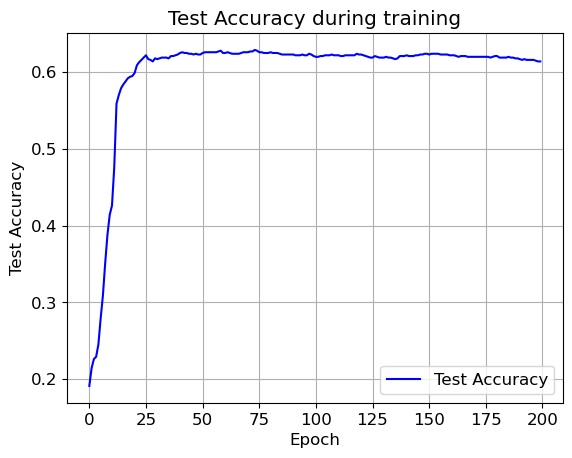

In [20]:
######################################################################### 
# visualize the accuracy on the test set as a function to the epochs

# Set the font size for the plot labels and title
plt.rcParams.update({'font.size': 12})

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training loss as a blue line
ax.plot(test_acc_list, 'b-', label='Test Accuracy')

# Add a legend to the plot
ax.legend(loc='lower right')

# Set the plot labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy during training')

# Add grid lines to the plot
ax.grid(True, which='both')

# Display the plot
plt.show()
######################################################################### 

In [21]:
######################################################################### 
# add your code here to run the experiment using original cora features
######################################################################### 
# instantiate another MLP with the same parameters
# MLP node using cora features
in_channels = data.x.shape[1]               # number of input features
out_channels = len(torch.unique(data.y))    # number of possible output classes
mlp_model = MLP(in_channels, out_channels)

######################################################################### 

######################################################################### 
#define a train function for your model
def train(model, data, optimizer, criterion, num_epochs):
    model.train()
    test_acc_list = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(data.x)
        loss = criterion(output[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        test_acc = test(model, data)
        test_acc_list.append(test_acc)
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {loss.item()} -  Accuracy: {test_acc:.4f}")
    return test_acc_list


######################################################################### 

######################################################################### 
#define a test function to your model
def test(model, data):
    model.eval()
    output = model(data.x)
    _, predicted = torch.max(output[data.test_mask], 1)     # get the classifications from the model's output
    accuracy = torch.sum(predicted == data.y[data.test_mask]).item() / data.test_mask.sum().item()
    return accuracy

######################################################################### 

######################################################################### 
#train your model and print the accuracy

test_acc_list = train(model=mlp_model, data=data, optimizer=torch.optim.Adam(mlp_model.parameters(), lr=0.01), criterion=nn.CrossEntropyLoss(), num_epochs=200)
acc = test(model=mlp_model, data=data)


######################################################################### 

Epoch 5/200 - Loss: 1.9443212747573853 -  Accuracy: 0.1590
Epoch 10/200 - Loss: 1.8291239738464355 -  Accuracy: 0.3030
Epoch 15/200 - Loss: 1.7055267095565796 -  Accuracy: 0.3910
Epoch 20/200 - Loss: 1.5701372623443604 -  Accuracy: 0.4820
Epoch 25/200 - Loss: 1.4354526996612549 -  Accuracy: 0.5270
Epoch 30/200 - Loss: 1.3150911331176758 -  Accuracy: 0.5300
Epoch 35/200 - Loss: 1.2180485725402832 -  Accuracy: 0.5520
Epoch 40/200 - Loss: 1.1415411233901978 -  Accuracy: 0.5820
Epoch 45/200 - Loss: 1.0808238983154297 -  Accuracy: 0.5930
Epoch 50/200 - Loss: 1.0297514200210571 -  Accuracy: 0.5940
Epoch 55/200 - Loss: 0.9849345684051514 -  Accuracy: 0.5970
Epoch 60/200 - Loss: 0.9477772116661072 -  Accuracy: 0.6020
Epoch 65/200 - Loss: 0.9191665649414062 -  Accuracy: 0.6080
Epoch 70/200 - Loss: 0.8983250856399536 -  Accuracy: 0.6100
Epoch 75/200 - Loss: 0.8829544186592102 -  Accuracy: 0.6130
Epoch 80/200 - Loss: 0.8703898191452026 -  Accuracy: 0.6130
Epoch 85/200 - Loss: 0.8591040372848511 -

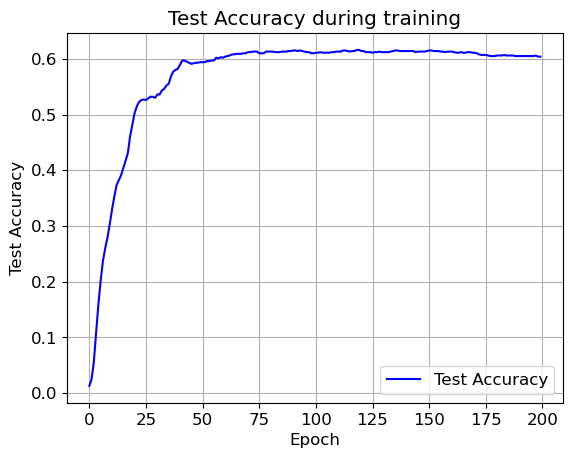

In [22]:
######################################################################### 
# visualize the accuracy on the test set as a function to the epochs

# Set the font size for the plot labels and title
plt.rcParams.update({'font.size': 12})

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training loss as a blue line
ax.plot(test_acc_list, 'b-', label='Test Accuracy')

# Add a legend to the plot
ax.legend(loc='lower right')

# Set the plot labels and title
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy during training')

# Add grid lines to the plot
ax.grid(True, which='both')

# Display the plot
plt.show()
######################################################################### 

In [23]:
######################################################################### 
# add your code here to run the label propagation


# had issues with data being redefined so for safety am including it above every section
cora_dataset = Planetoid(root="", name="Cora", split="public")
data = cora_dataset[0]

# Create a networkx graph from the data
G = nx.Graph()
G.add_edges_from(data.edge_index.T.tolist())

# Get the output class labels for each node
labels = data.y.tolist()

encoder = OneHotEncoder()
all_labels = encoder.fit_transform(data.y.reshape(-1, 1)).toarray()

######################################################################### 

######################################################################### 
# mask the val and test labels
tr_labels = np.zeros_like(all_labels)
# val_labels = np.zeros_like(all_labels) --- not used
tr_labels[data.train_mask] = all_labels[data.train_mask] 
# val_labels[data.val_mask] = all_labels[data.val_mask] --- not used

#########################################################################

######################################################################### 
# transition matrix as adjacency matrix
transition_matrix = nx.adjacency_matrix(G)

# row normalization
row_sum = np.sum(transition_matrix, axis=1)
transition_matrix = transition_matrix / row_sum[:,None]

######################################################################### 

######################################################################### 
# write code here to run the label propagation algorithm for 10 epochs
# run the label propagation algorithm for 10 epochs
for epoch in range(10):
    tr_labels = np.dot(transition_matrix, tr_labels)

#getting the predicted labels
pred_labels = tr_labels[data.test_mask]
true_labels = all_labels[data.test_mask]
accuracy = metrics.accuracy_score(np.argmax(true_labels, axis=1), np.argmax(pred_labels, axis=1))
print("Accuracy: ", accuracy)

######################################################################### 

Accuracy:  0.11


### 🕵 <font color='289C4E'>Question<font><a class='anchor' id='top'></a>

**(g)Compare the performance of different methods. Which method is affected most by the increase in training set size? Explain the possible reasons behind your observation in the following cell:**

Answer: HANDCRAFTED. The pattern can only be recognized when more samples are available. 

---